In [1]:
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import os, sys
import contextlib
import random
import warnings


sys.path.append(os.path.join(os.getcwd(), 'utils'))

from utils.data_loading import *
from utils.data_processing import *
from utils.regression import *
from utils.animation import *
from utils.metrics import *
from utils.pipeline import *

# autoreload
%reload_ext autoreload
%autoreload 2

# ignore userwarnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Get the current working directory
current_dir = os.getcwd()

# Define the path to the data
data_path = os.path.join(current_dir, 'data')
filename = 'ssp585_time_series.pkl'

print(f"Data path: {data_path}")

# Set the plotting parameters
lat_min, lat_max = -90, 60
lon_min, lon_max = 0, 360

Data path: /mydata/cope/luc/data


# Import and preprocess the data

In [2]:
# Preprocess the data
data, nan_mask = preprocess_data(data_path, filename)

Loading data from ssp585_time_series.pkl
Data loaded successfully.
Filtering data...


100%|██████████| 72/72 [00:00<00:00, 27568.91it/s]

ICON-ESM-LR r1i1p1f1
Data has shape: (165, 60, 144)
Data filtered. Kept 34 models
Creating NaN mask...



100%|██████████| 34/34 [00:01<00:00, 20.01it/s]

NaN mask created.
Masking out NaN values...



100%|██████████| 34/34 [00:02<00:00, 16.39it/s]

NaN values masked out.
Reshaping data...



100%|██████████| 34/34 [00:05<00:00,  5.67it/s]

Data reshaped.
Adding the forced response to the data...



100%|██████████| 34/34 [00:05<00:00,  6.59it/s]

Forced response added.
Removing NaN values from the grid...



100%|██████████| 34/34 [00:04<00:00,  7.24it/s]

NaN values removed.


## Chose the parameters for the reduced rank regression (RRR)

In [3]:
best_rank, best_lambda = 2, 1000

## Choose one test model and set the rest as training data

In [4]:
models = list(data.keys())
test_model = 'MIROC-ES2L'
print(f"Testing model: {test_model}")

train_models = [model for model in models if model != test_model]
train_data = {model: data[model] for model in train_models}
test_data = {test_model: data[test_model]}

Testing model: MIROC-ES2L


# Normalize the data before fitting the model

In [5]:
center = True # Don't standardize by the std
option = 1 # If you set option to 1 you normalize with mean of shape (d,) and with option 2 you normalize with mean of shape (d, T) so one mean per grid cell per time step.
normalized_train_data, normalized_test_data, _, testing_statistics = normalize_data(train_data, test_data, center=center, option=option)


Normalizing data...


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

Data normalization completed.


## Pool the training and testing data into matrices for training

In [6]:
X_train, Y_train = pool_data(normalized_train_data)


Pooling data...


100%|██████████| 33/33 [00:00<00:00, 165762.91it/s]

Data pooled.


# Fit the RRR model to the training data

In [7]:
use_ols_only = False # Set to True if you want to use OLS only, False for reduced rank regression (which uses the SVD)
B_rrr, B_ols = reduced_rank_regression(X_train, Y_train, best_rank, best_lambda, use_ols_only=use_ols_only)

Fitting OLS...


Computing SVD...
OLS and SVD computation took 141.8436 seconds.
RRR completed.


## Get all the test runs and ground truth (forced response) for the testing data

In [8]:
test_runs = [run for run in normalized_test_data[test_model].keys() if run != 'forced_response']
ground_truth = normalized_test_data[test_model]['forced_response']

In [9]:
# Calculate the normalised MSE for each run in the test set
normalise = True  # Set to True if you want to normalise the MSE by the variance of the ground truth
test_runs_mse = []
for run in test_runs:
    test_run_data = normalized_test_data[test_model][run]
    mse = calculate_mse(test_run_data, B_rrr, ground_truth, testing_statistics, test_model, normalise)
    test_runs_mse.append(mse)

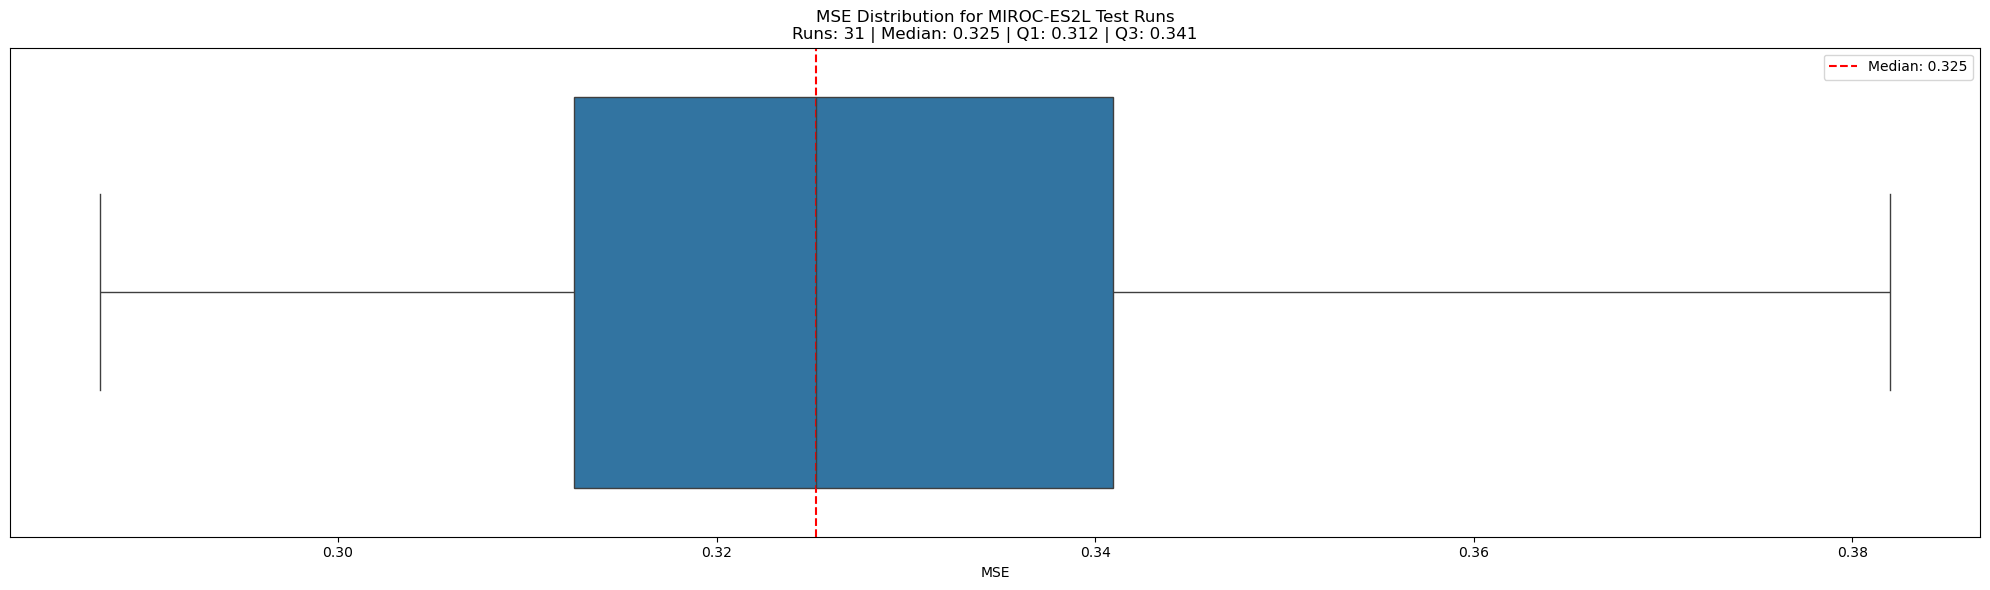

In [10]:
# Plot the distribution of MSE for the test runs with median and quartiles
plt.figure(figsize=(20, 6))
ax = sns.boxplot(data=test_runs_mse, orient='h')

median = np.median(test_runs_mse)
q1 = np.percentile(test_runs_mse, 25)
q3 = np.percentile(test_runs_mse, 75)
n_runs = len(test_runs_mse)

plt.axvline(median, color='red', linestyle='--', label=f'Median: {median:.3f}')
plt.title(f'MSE Distribution for {test_model} Test Runs\n'
          f'Runs: {n_runs} | Median: {median:.3f} | Q1: {q1:.3f} | Q3: {q3:.3f}')
plt.xlabel('MSE')
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()

# Plot the time evolution of a test run and the ground truth

In [11]:
# print the shape of a test run
normalized_test_forced_response = readd_nans_to_grid(normalized_test_data[test_model]['forced_response'], nan_mask, True).reshape(165,60,144)

Re-adding NaN values to the grid...


In [12]:
animated_test_gt = animate_data(normalized_test_forced_response, interval=200, cmap='viridis', extent=[lon_min, lon_max, lat_min, lat_max], title=f'Normalized Test Data: {test_model}')
display(HTML(animated_test_gt.to_html5_video()))

## Select a run from the test data and plot the RRR prediction

In [13]:
test_runs = list(test_data[test_model].keys())
test_run = 'r29i1p1f2'
test_run_data = normalized_test_data[test_model][test_run]

# Get the prediction by using the RRR coefficients
test_run_prediction = test_run_data @ B_rrr

# Calculate the normalized MSE for the test run
mse_test_run = calculate_mse(test_run_data, B_rrr, ground_truth, testing_statistics, test_model, normalise=True)

# Readd the nans to the grid to show the animation
test_run_prediction = readd_nans_to_grid(test_run_prediction, nan_mask, True).reshape(165, 60, 144)
animated_test_run = animate_data(test_run_prediction, interval=200, cmap='viridis', extent=[lon_min, lon_max, lat_min, lat_max], title=f'Normalized Test Run Prediction: MSE: {mse_test_run:.3f}')
display(HTML(animated_test_run.to_html5_video()))

Re-adding NaN values to the grid...


## Next we will plot a single grid cell from the RRR prediction to see if the model is able to capture the warming pattern

Displaying the forced response and runs for grid spot: (0, 127)
Re-adding NaN values to the grid...


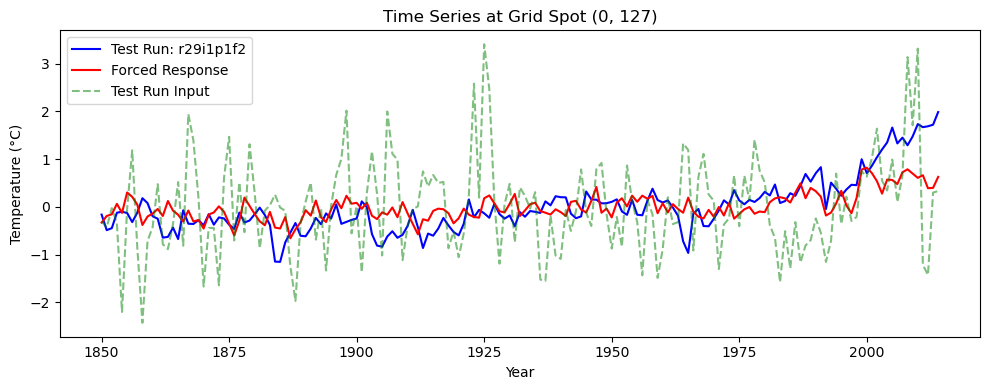

In [14]:
# Select a grid point to visualize the time series
grid_x, grid_y = 0, 127
print(f"Displaying the forced response and runs for grid spot: {grid_x, grid_y}")

# Prepare the test run and ground truth data for the selected grid point
test_run_input = readd_nans_to_grid(test_run_data, nan_mask, True).reshape(165, 60, 144)[:, grid_x, grid_y]
test_run_data_grid = test_run_prediction[:, grid_x, grid_y]
ground_truth_grid = normalized_test_forced_response[:, grid_x, grid_y]

years = np.arange(1850, 1850 + len(test_run_data_grid))

# Plot both time series on the same plot
plt.figure(figsize=(10, 4))
plt.plot(years, test_run_data_grid, color='blue', label=f'Test Run: {test_run}')
plt.plot(years, ground_truth_grid, color='red', label='Forced Response')
plt.plot(years, test_run_input, color='green', linestyle='--', label='Test Run Input', alpha=0.5)
plt.title(f'Time Series at Grid Spot ({grid_x}, {grid_y})')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.tight_layout()
plt.show()


## Next we will get all the predictions for the test data and plot them for a single grid cell

Displaying the forced response and runs for grid spot: (0, 127)


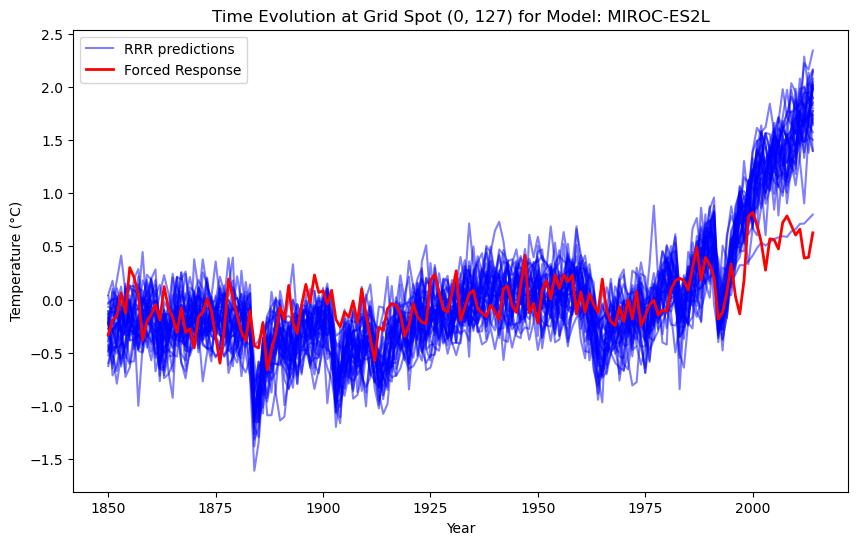

In [15]:
# Select a random
print(f"Displaying the forced response and runs for grid spot: {grid_x, grid_y}")

# Get predictions for all test runs at the selected grid spot
predictions = []
for run in test_runs:
    test_run_data = normalized_test_data[test_model][run]
    pred = test_run_data @ B_rrr
    with open(os.devnull, 'w') as fnull: # Redirect the stdout to avoid printing the progress
        with contextlib.redirect_stdout(fnull):
            pred_grid = readd_nans_to_grid(pred, nan_mask, True).reshape(165, 60, 144)[:, grid_x, grid_y]
    predictions.append(pred_grid)

# Get the forced response at the selected grid spot
forced_response_grid = normalized_test_forced_response[:, grid_x, grid_y]

years = np.arange(1850, 1850 + len(forced_response_grid))

# Plot all predictions in blue and the forced response in red
plt.figure(figsize=(10, 6))
for i, pred in enumerate(predictions):
    if i == 0:
        plt.plot(years, pred, color='blue', alpha=0.5, label='RRR predictions')
    else:
        plt.plot(years, pred, color='blue', alpha=0.5)
plt.plot(years, forced_response_grid, color='red', label='Forced Response', linewidth=2)
plt.title(f'Time Evolution at Grid Spot ({grid_x}, {grid_y}) for Model: {test_model}')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

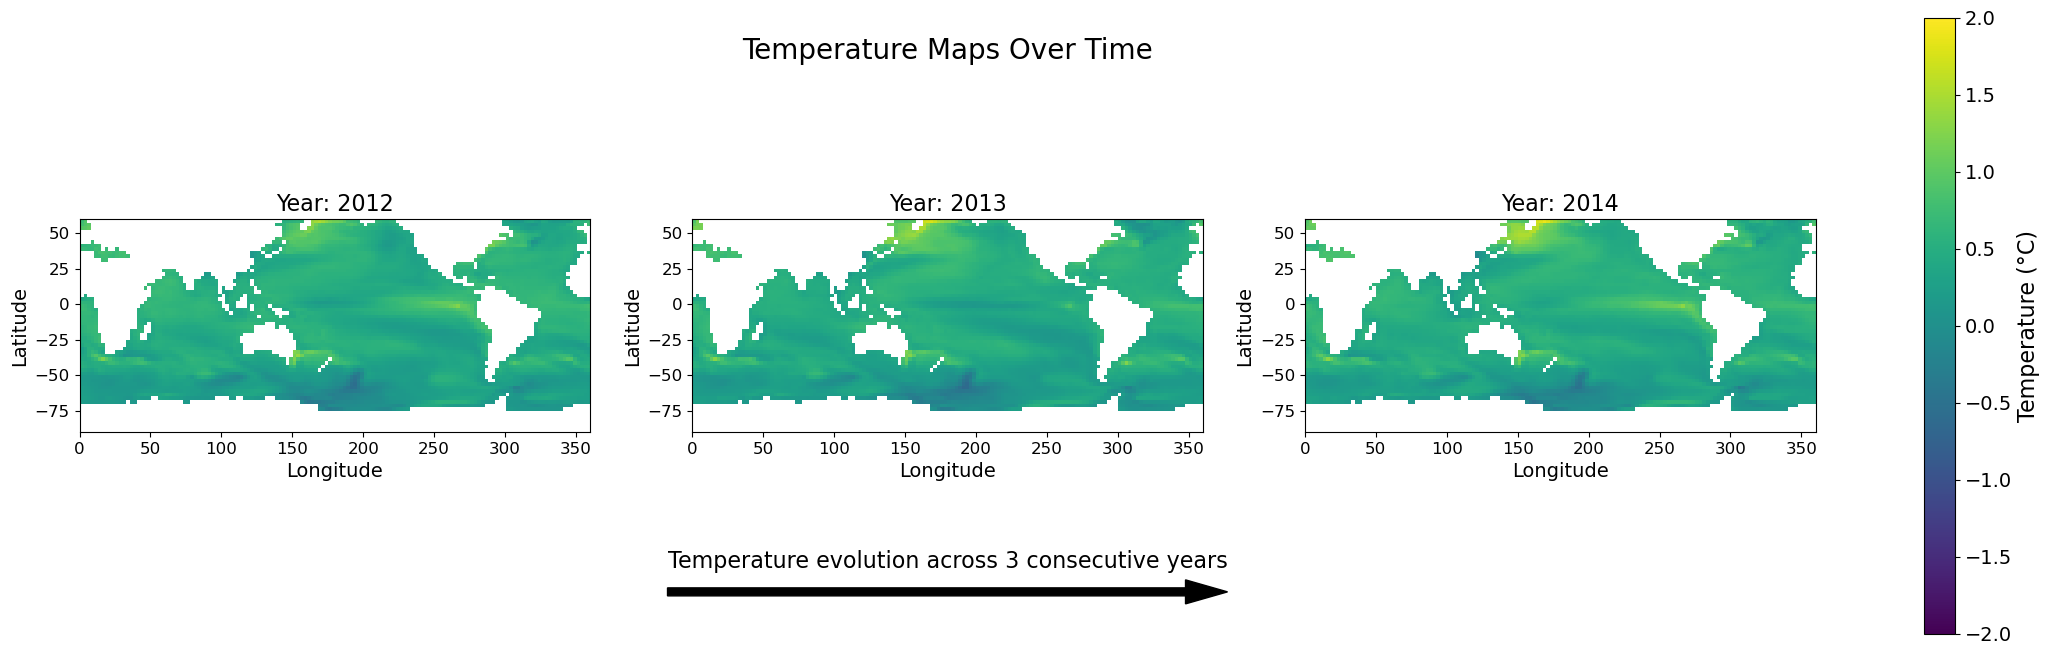

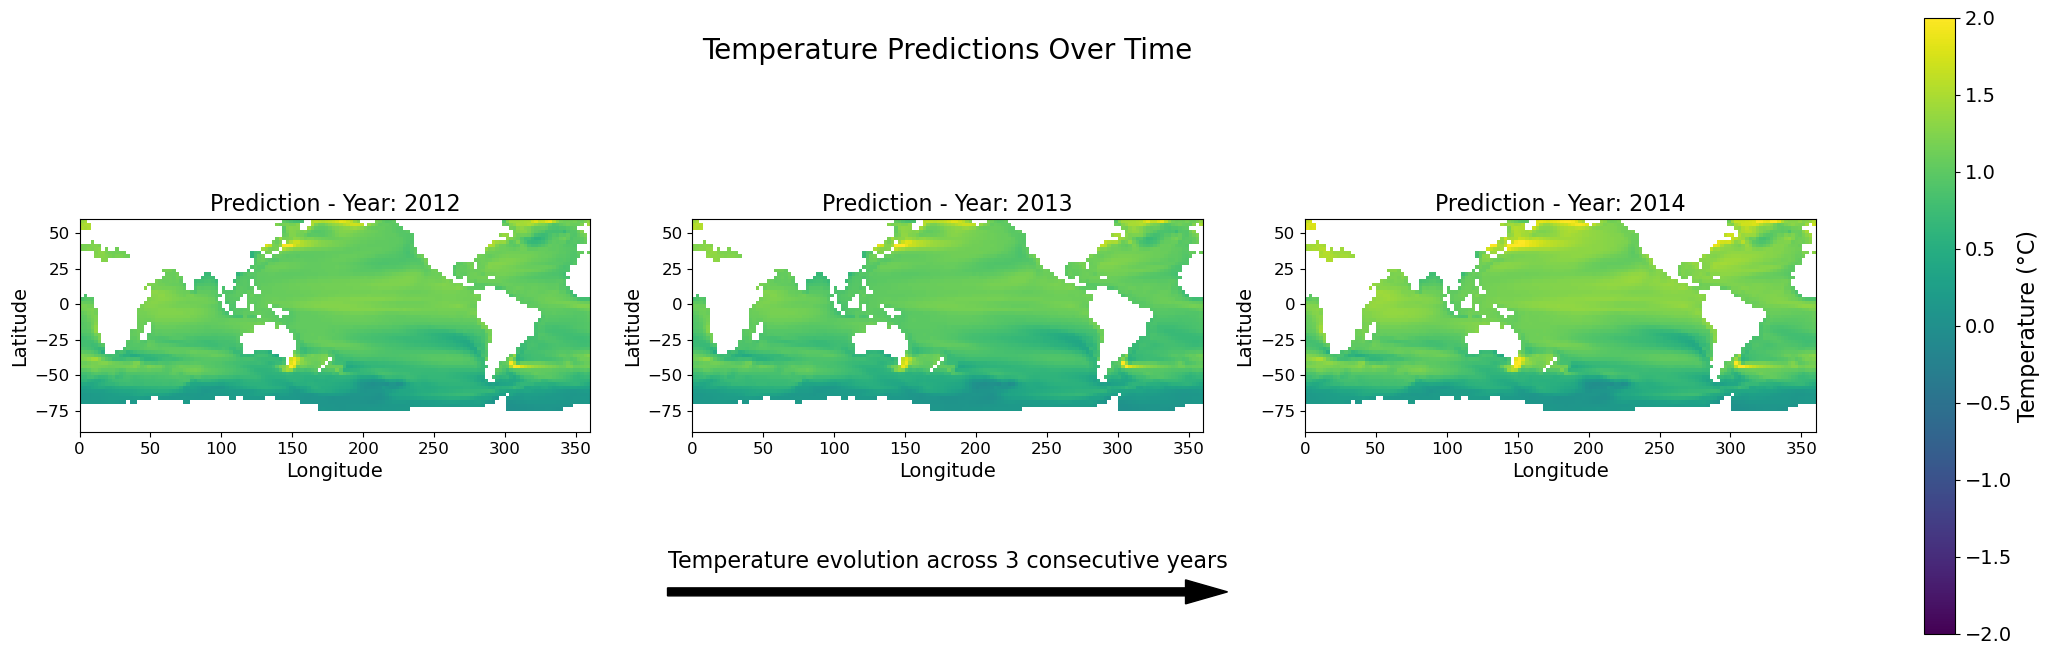

In [16]:
# Determine the most extreme values for consistent color scaling
vmin = -2
vmax = 2

# Plot the maps for 3 consecutive timestamps with an arrow indicating time progression and a global title

# Ensure the output directory exists
output_dir = os.path.join(current_dir, 'report_outputs')
os.makedirs(output_dir, exist_ok=True)

# Plot the maps for 3 consecutive timestamps
fig, axes = plt.subplots(1, 3, figsize=(28, 8))
start_timestamp = 162  # Example starting timestamp
timestamps = [start_timestamp, start_timestamp + 1, start_timestamp + 2]  # Consecutive timestamps

for i, timestamp in enumerate(timestamps):
    ax = axes[i]
    im = ax.imshow(normalized_test_forced_response[timestamp], cmap='viridis', extent=[lon_min, lon_max, lat_min, lat_max], vmin=vmin, vmax=vmax)
    ax.set_title(f'Year: {1850+timestamp}', fontsize=16)
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    ax.tick_params(labelsize=12)

# Add a colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical')
cbar.set_label('Temperature (°C)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Add a global title
mid_ax = axes[1]
mid_ax_pos = mid_ax.get_position()
title_x = (mid_ax_pos.x0 + mid_ax_pos.x1) / 2
title_y = mid_ax_pos.y1 + 0.20  # Slightly above the top of the middle axis

fig.text(title_x, title_y, 'Temperature Maps Over Time', ha='center', fontsize=20)

# Arrow positioned below second subplot
arrow_y = mid_ax_pos.y0 - 0.2
arrow_length = 0.2  # reasonable width for clarity

arrow = patches.FancyArrow(
    (mid_ax_pos.x0 + mid_ax_pos.x1) / 2 - arrow_length / 2, arrow_y,
    arrow_length, 0, width=0.01,
    head_width=0.03, head_length=0.015,
    length_includes_head=True,
    color='black',
    transform=fig.transFigure
)
fig.patches.append(arrow)

# Text above the arrow
fig.text((mid_ax_pos.x0 + mid_ax_pos.x1) / 2, arrow_y + 0.03, 'Temperature evolution across 3 consecutive years', ha='center', fontsize=16)

# Save the figure
output_path = os.path.join(output_dir, 'map_consecutive_timestamps_with_arrow.png')
plt.savefig(output_path)
plt.show()

# Compare predictions of a run for the same timestamps
fig, axes = plt.subplots(1, 3, figsize=(28, 8))
for i, timestamp in enumerate(timestamps):
    ax = axes[i]
    im = ax.imshow(test_run_prediction[timestamp], cmap='viridis', extent=[lon_min, lon_max, lat_min, lat_max], vmin=vmin, vmax=vmax)
    ax.set_title(f'Prediction - Year: {1850+timestamp}', fontsize=16)
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    ax.tick_params(labelsize=12)

# Add a colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical')
cbar.set_label('Temperature (°C)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Add a global title
fig.text(title_x, title_y, 'Temperature Predictions Over Time', ha='center', fontsize=20)

# Arrow positioned below second subplot
arrow_y = mid_ax_pos.y0 - 0.2
arrow_length = 0.2  # reasonable width for clarity

arrow = patches.FancyArrow(
    (mid_ax_pos.x0 + mid_ax_pos.x1) / 2 - arrow_length / 2, arrow_y,
    arrow_length, 0, width=0.01,
    head_width=0.03, head_length=0.015,
    length_includes_head=True,
    color='black',
    transform=fig.transFigure
)
fig.patches.append(arrow)

# Text above the arrow
fig.text((mid_ax_pos.x0 + mid_ax_pos.x1) / 2, arrow_y + 0.03, 'Temperature evolution across 3 consecutive years', ha='center', fontsize=16)


# Save the figure
output_path = os.path.join(output_dir, 'predictions_over_time.png')
plt.savefig(output_path)
plt.show()